In [1]:
import os
import sys
import pickle as pkl
import pandas as pd
import numpy as np
import os
import sys
from matplotlib import cm
from matplotlib import pyplot as plt
import seaborn as sns

#from utils import helpers
from utils import add_features
from utils.stats_and_plot_utils import multitest_BH,\
    compute_pvalues,\
        annot_stat,\
            clean_df_total,\
                plot_microorganism_counts,\
                    plot_peptide_dist,\
                    create_relative_abund_plots_single,\
                    plot_species,\
                    parse_and_plot_species



In [2]:
# Open csv file containing library information
# First unzip file if necessary (from command line: xzcat data/df_agilent_with_info.csv.xz > data/df_agilent_with_info.csv)
df_agilent_raw = pd.read_csv('data/df_agilent_with_info.csv', sep='\t', index_col=0)

/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/642412015.py:3: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_agilent_raw = pd.read_csv('data/df_agilent_with_info.csv', sep='\t', index_col=0)


In [3]:
# Add functional annotations
df_agilent = add_features.map_predictions(df_agilent_raw)

In [4]:
# Import GWAS tables
# Download file from https://ars.els-cdn.com/content/image/1-s2.0-S1074761323001711-mmc3.xlsx
# Open the sheets 2.2 and 2.3 which contain significant genetic associations and significant genetic imputations to HLA
df = pd.read_excel('data/1-s2.0-S1074761323001711-mmc3.xlsx', sheet_name='SupTable2.3')
df2_2 = pd.read_excel('data/1-s2.0-S1074761323001711-mmc3.xlsx', sheet_name='SupTable2.2')
# And all peptides used in GWAS analysis in sheet 1.1 (https://ars.els-cdn.com/content/image/1-s2.0-S1074761323001711-mmc2.xlsx)
df_GWAS = pd.read_excel('data/1-s2.0-S1074761323001711-mmc2.xlsx', sheet_name='SupTable1.1')

In [5]:
# Get unique peptides in imputation file (lowest Bonferroni_p_value)
df_unique = pd.DataFrame(df.sort_values('peptide').groupby('peptide')['Bonferroni_ind'].min().reset_index(0))

# Get peptides which are only HLA associated
df_agilent_final = df_agilent[df_agilent['peptide_name'].isin(df_unique['peptide'])]

# Get all peptides used in GWAS and remove the ones which have imputations to HLA alleles
list_GWAS_peptides = df_GWAS[df_GWAS['Peptide'].str.contains('agilent')]['Peptide'].unique()
df_tested_agilent = df_agilent[df_agilent['peptide_name'].isin(list_GWAS_peptides)]
df_tested_agilent_clean = df_tested_agilent[df_tested_agilent['peptide_name'].
                                            isin(df_agilent_final['peptide_name']) == False]
# This is for subtracting the peptides that are labelled as HLA associated 
# from the set of bound peptides (GWAS tested)
# peptides_HLA = df2_2[(df2_2['P.value'] <= 5.67e-11) & (df2_2['CHR'] ==6) & (df2_2['peptide'].str.contains('agilent'))]['peptide'].unique()
# df_HLA_GWAS = df_agilent[df_agilent['peptide_name'].isin(peptides_HLA)]
# df_tested_agilent_clean2 = df_tested_agilent[df_tested_agilent['peptide_name'].
#                                              isin(df_HLA_GWAS['peptide_name']) == False]

# Now create a table also for all the rest of the peptides (Entire library, cleaning from all the peptides that were tested
# or HLA associated)
agilent_total_clean2 = df_agilent[df_agilent['peptide_name'].isin(df_tested_agilent['peptide_name']) == False]



In [6]:
# Use these annotations and features
# Get relevant features
relevant_agilent = ['is_infect', 'is_patho', 'is_toxin','is_EBV',
       'is_EM', 'is_MPA', 'is_IgA', 'is_probio', 'is_auto', 'is_pos_cntrl', 'is_neg_cntrl',
       'is_rand_cntrl'] # 'is_infect' outside and put in 
renamed_agilent = ['ImmunoEpitope DB (infectious pathogens)', 'Gut pathogens', 'Virulence Factor DB','Epstein-Barr Virus',
            'Microbiota genes', 'Microbiota strains',
            'Antibody-coated strains', 'Probiotic strains', 'Human Autoantigens', 'Positive control', 'Negative control', 'Random control',
           ]
relevant_functional_agilent = ['signalp6_slow',
                               'diamond_mmseqs_intersec_toxin',
                               'is_flagellum',
                               'is_topgraph_new_&_old']
renamed_agilent_func = ['Secreted proteins (signalp6)',
                        'Toxin (mmseqs+diamond intersec)',
                        'Flagellum proteins (metadata+diamond)',
                        'Membrane proteins (topgraph new+old sum)']


Correction DONE
{'Secreted proteins (signalp6)': array([1.20453400e-01, 1.64397393e-10, 4.06683077e-07]), 'Toxin (mmseqs+diamond intersec)': array([0.00897687, 0.03132138, 0.00190696]), 'Flagellum proteins (metadata+diamond)': array([2.39341463e-21, 1.72556492e-01, 1.22410033e-05]), 'Membrane proteins (topgraph new+old sum)': array([1.11757901e-05, 7.90863750e-07, 7.02946241e-03])}
defaultdict(<class 'list'>, {'signalp6_slow': [109374, 715, 203], 'diamond_mmseqs_intersec_toxin': [39966, 211, 68], 'is_flagellum': [5100, 99, 3], 'is_topgraph_new_&_old': [116867, 643, 109]})


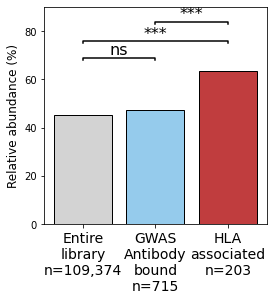

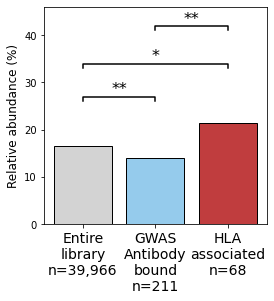

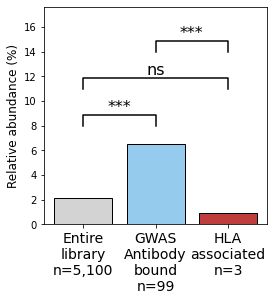

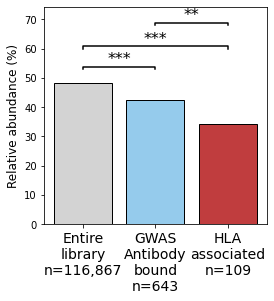

In [7]:
# Plot functions
colors = ['lightgrey', 'lightskyblue', 'tab:red']
classes = ['Entire library', 'GWAS\nAntibody bound', 'HLA associated']
create_relative_abund_plots_single([agilent_total_clean2,
                             df_tested_agilent_clean,
                             df_agilent_final],
                            relevant_functional_agilent,
                            renamed_agilent_func,
                            color=colors,
                            multitest_correction=True,
                            classes=classes,
                            count_on_bars=False
                           )

Correction DONE
{'ImmunoEpitope DB (infectious pathogens)': array([1.35284212e-55, 8.13736491e-23, 9.81803221e-02]), 'Gut pathogens': array([3.34345320e-01, 4.43968633e-09, 7.20375154e-06]), 'Virulence Factor DB': array([5.23527862e-48, 1.18270149e-25, 4.52815770e-03]), 'Epstein-Barr Virus': array([1.51037829e-02, 5.47732469e-08, 1.31151478e-02]), 'Microbiota genes': array([3.28108595e-65, 3.21944710e-56, 1.29721227e-13]), 'Microbiota strains': array([9.22612322e-14, 2.58945466e-14, 5.12979045e-05]), 'Antibody-coated strains': array([0.05879564, 1.        , 0.70036898]), 'Probiotic strains': array([0.13899721, 1.        , 0.52731307]), 'Human Autoantigens': array([0.13899721, 0.11117624, 0.52731307]), 'Positive control': array([9.77551370e-45, 1.62563162e-13, 7.00368980e-01]), 'Negative control': array([0.21823883, 1.        , 1.        ]), 'Random control': array([1., 1., 1.])}
defaultdict(<class 'list'>, {'is_infect': [4076, 139, 41], 'is_patho': [24617, 166, 69], 'is_toxin': [23720,

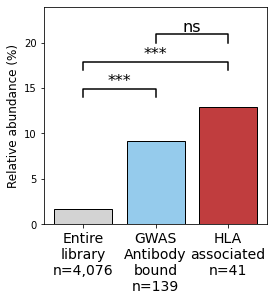

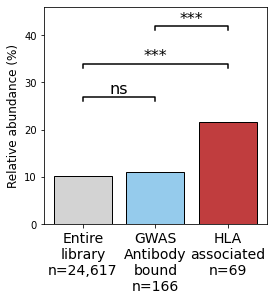

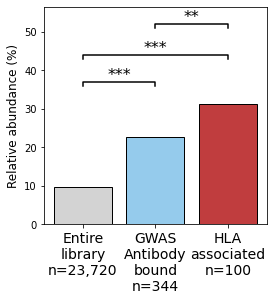

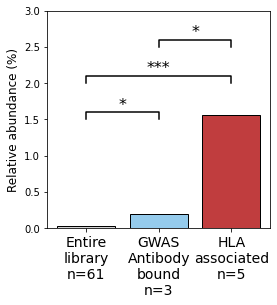

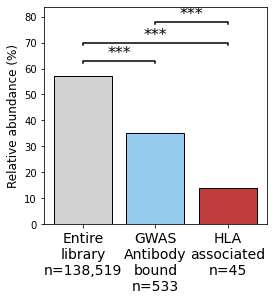

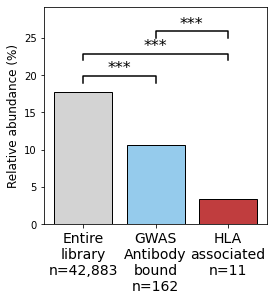

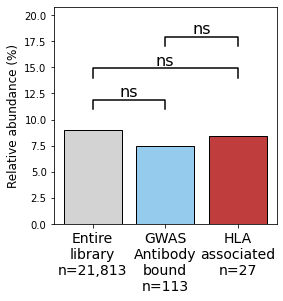

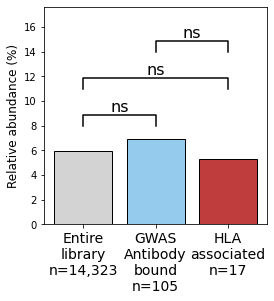

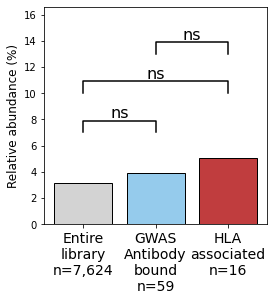

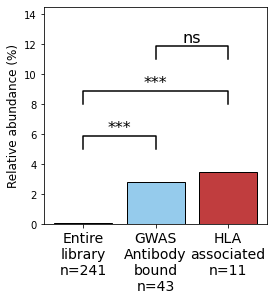

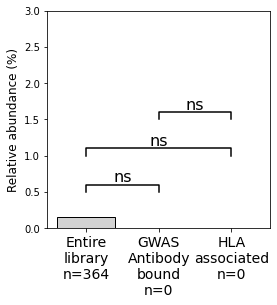

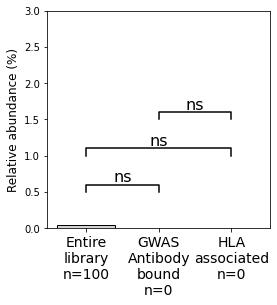

In [8]:
# Plot categories
colors = ['lightgrey', 'lightskyblue', 'tab:red']
classes = ['Entire library', 'GWAS\nAntibody bound', 'HLA associated']
create_relative_abund_plots_single([agilent_total_clean2,
                             df_tested_agilent_clean,
                             df_agilent_final]#
                             ,
                            relevant_agilent,
                            renamed_agilent,
                            color=colors,
                            multitest_correction=True,
                            classes=classes,
                            count_on_bars=False,
                           )

### Here we use organism information and protein name infos.
Code for now is too redundant, to optimize in a future update.

In [9]:
df_bonf = pd.DataFrame(df.groupby('peptide').min('Bonferroni_ind'))
df_bonf[df_bonf.index.str.contains('agilent')].index
df_bonf.reset_index(inplace=True)

In [10]:
df_unique.columns = ['peptide', 'Bonferroni_min']

bonferroni_agilent_df = df_unique[df_unique['peptide'].str.contains('agil')][['peptide', 'Bonferroni_min']]
merge_bonf_agilent_df = pd.merge(df_agilent, bonferroni_agilent_df, left_on='peptide_name', right_on='peptide').sort_values(by='Bonferroni_min')
merge_bonf_agilent_df = merge_bonf_agilent_df.drop(columns='peptide')

# now for each group (Toxins, Gut Patho, IEDB, EBV, Microbiota genes, Microbiota strains) create a table
groups = ['is_infect', 'is_EBV',
    'is_toxin', 'is_EM', 'is_MPA', 'is_patho']

merge_bonf_agilent_df['Taxon'] = merge_bonf_agilent_df['Organism_complete_name']
merge_bonf_agilent_df['Taxon (uniref)'] = merge_bonf_agilent_df['uniref_func'].dropna().apply(lambda x: x.split(' Tax=')[1].split(' T')[0])
merge_bonf_agilent_df['Taxon (IEDB)'] = merge_bonf_agilent_df['IEDB_organism_name']
merge_bonf_agilent_df['Taxon (VFDB)'] = merge_bonf_agilent_df['toxin_prot_name']
merge_bonf_agilent_df['Taxon (src)'] = merge_bonf_agilent_df['bac_src']

merge_bonf_agilent_df['Protein name (uniref)'] = merge_bonf_agilent_df['uniref_func'].dropna().apply(lambda x: x.split(' n=')[0])
merge_bonf_agilent_df
# Uncomment to use secreted proteins which are not also membrane 
# array_others = np.where((merge_bonf_agilent_df['secreted_not_attached'] == 0) & (merge_bonf_agilent_df['is_topgraph_new_&_old'] == 0))[0]
# print(array_others)
# merge_bonf_agilent_df['Type'] = np.where(merge_bonf_agilent_df['secreted_not_attached'] == 1, 'Secreted', 'Membrane attached')
# merge_bonf_agilent_df.loc['Type']
# merge_bonf_agilent_df.loc[array_others,'Type'] = 'Other'
merge_bonf_agilent_df['Protein name (uniref) and pos'] = merge_bonf_agilent_df['Protein name (uniref)'] + (' (pos. ' + merge_bonf_agilent_df['pos'].astype(str) + ' - ' + (merge_bonf_agilent_df['pos'] + 64).astype(str) + ')')


In [11]:
# now for each group (Toxins, Gut Patho, IEDB, EBV, Microbiota genes, Microbiota strains) create a table for HLA associated
groups = ['is_infect', 'is_EBV',
    'is_toxin', 'is_EM', 'is_MPA', 'is_patho']

a = merge_bonf_agilent_df[['peptide_name', 'is_infect', 'is_EBV', 'bac_src',
    'is_toxin', 'is_EM', 'is_MPA', 'is_patho', 'IEDB_organism_name', 'toxin_prot_name', 'uniref_func', 'Bonferroni_min',
    'is_flagellum', 'diamond_mmseqs_intersec_toxin', 'signalp6_slow', 'is_topgraph_new_&_old', 'Taxon']]

def make_table_sources(x, i, concat):
    
    if i == 'is_infect':
        #x['organism_name'] = x['IEDB_organism_name'].apply(lambda x: x.split('\'')[1].strip())
        x['organism_name'] = x['Taxon']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'Bonferroni_min', 'class']]
        concat.append(x)
        # x.to_excel('Test_annotations_groups_AntibodyBound_and_HLA_assoc.xlsx', sheet_name=i)
    if i == 'is_EBV':
        #x['organism_name'] = 'Epstain-Barr virus'
        x['organism_name'] = 'Epstein-Barr'
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'Bonferroni_min', 'class']]
        concat.append(x)
        # with pd.ExcelWriter('Test_annotations_groups_AntibodyBound_and_HLA_assoc.xlsx', mode='a') as writer:
        #      x.to_excel(writer, sheet_name=i, index=False)
    if i == 'is_toxin':
        #x['organism_name'] = x['toxin_prot_name'].apply(lambda x: x.split('[')[2].split(']')[0].strip())
        x['organism_name'] = x['Taxon']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'Bonferroni_min', 'class']]
        concat.append(x)
        # with pd.ExcelWriter('Test_annotations_groups_AntibodyBound_and_HLA_assoc.xlsx', mode='a') as writer:
        #      x.to_excel(writer, sheet_name=i, index=False)
    if i == 'is_EM':
        #x['organism_name_uniref'] = x['uniref_func'].apply(lambda x: x.split(' Tax=')[1].split(' T')[0].strip() + ' (uniref annot)')
        #x['organism_name_tox'] = x['bac_src'].apply(lambda x: x.split(' &')[0].strip() if type(x) != float else x)
        #x['organism_name'] = x['organism_name_tox'].fillna(x['organism_name_uniref'])
        x['organism_name'] = x['Taxon']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'Bonferroni_min', 'class']]
        concat.append(x)
        # with pd.ExcelWriter('Test_annotations_groups_AntibodyBound_and_HLA_assoc.xlsx', mode='a') as writer:
        #      x.to_excel(writer, sheet_name=i, index=False)
    if i == 'is_MPA':
        #x['organism_name'] = x['bac_src'].apply(lambda x: x.split(' &')[0].strip())
        x['organism_name'] = x['Taxon']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'Bonferroni_min', 'class']]
        concat.append(x)
        # with pd.ExcelWriter('Test_annotations_groups_AntibodyBound_and_HLA_assoc.xlsx', mode='a') as writer:
        #      x.to_excel(writer, sheet_name=i, index=False)
    if i == 'is_patho':
        #x['organism_name'] = x['bac_src'].apply(lambda x: x.split(' &')[0].strip())
        x['organism_name'] = x['Taxon']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'Bonferroni_min', 'class']]
        concat.append(x)
        # with pd.ExcelWriter('Test_annotations_groups_AntibodyBound_and_HLA_assoc.xlsx', mode='a') as writer:
        #      x.to_excel(writer, sheet_name=i, index=False)
    return concat
# use bac_src for is_MPA and is_patho.
# use IEDB_organism_name for is_infect
# use 'Epstain-Barr virus' for is_EBV
# use toxin_prot_name for is_toxin
# use uniref_func for is_EM
concat = []
for i in groups:
    x = a[a[i] == 1]
    x['Protein name (uniref)'] = x['uniref_func'].apply(lambda x: x.split(' n=')[0].strip())
    concat = make_table_sources(x, i, concat)
HLA_species = pd.concat(concat)

# Same for GWAS tested and entire library
concat = []
for i in groups:
    x = df_tested_agilent_clean[df_tested_agilent_clean[i] == 1]
    x['Protein name (uniref)'] = x['uniref_func'].apply(lambda x: x.split(' n=')[0].strip())
    if i == 'is_infect':
        #x['organism_name'] = x['IEDB_organism_name'].apply(lambda x: x.split('\'')[1].strip())
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        concat.append(x)
    if i == 'is_EBV':
        print(x[x[i] == 1])
        x['organism_name'] = 'Epstein-Barr'
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        # print(i, len(x['organism_name'].unique()))
        concat.append(x)
    if i == 'is_toxin':
        #x['organism_name'] = x['toxin_prot_name'].apply(lambda x: x.split('[')[2].split(']')[0].strip())
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        # print(i, len(x['organism_name'].unique()))
        concat.append(x)
    if i == 'is_EM':
        #x['organism_name_uniref'] = x['uniref_func'].apply(lambda x: x.split(' Tax=')[1].split(' T')[0].strip() + ' (uniref annot)')
        #x['organism_name_tox'] = x['bac_src'].apply(lambda x: x.split(' &')[0].strip() if type(x) != float else x)
        #x['organism_name'] = x['organism_name_tox'].fillna(x['organism_name_uniref'])
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        # print(i, len(x['organism_name'].unique()))
        concat.append(x)
    if i == 'is_MPA':
        #x['organism_name'] = x['bac_src'].apply(lambda x: x.split(' &')[0].strip())
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        # print(i, len(x['organism_name'].unique()))
        concat.append(x)
    if i == 'is_patho':
        #x['organism_name'] = x['bac_src'].apply(lambda x: x.split(' &')[0].strip())
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        # print(i, len(x['organism_name'].unique()))
        concat.append(x)
GWAS_species = pd.concat(concat)

# Now all data
agilent_total_clean2_taxa = agilent_total_clean2[agilent_total_clean2['uniref_func'].str.contains('Tax=') == True]
concat = []
for i in groups:
    x = agilent_total_clean2_taxa[(agilent_total_clean2_taxa[i] == 1) & (agilent_total_clean2_taxa['uniref_func'].isnull() == False)]
    x['Protein name (uniref)'] = x['uniref_func'].apply(lambda x: x.split(' n=')[0].strip())
    if i == 'is_infect':
        #x['organism_name'] = x['IEDB_organism_name'].apply(lambda x: x.split('\'')[1].strip())
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        
        concat.append(x)
    if i == 'is_EBV':
        x['organism_name'] = 'Epstein-Barr'
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        
        concat.append(x)
    if i == 'is_toxin':
        #x['organism_name'] = x['toxin_prot_name'].apply(lambda x: x.split('[')[2].split(']')[0].strip())
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        
        concat.append(x)
    if i == 'is_EM':
        #x['organism_name_uniref'] = x['uniref_func'].apply(lambda x: x.split(' Tax=')[1].split(' T')[0].strip() + ' (uniref annot)')
        #x['organism_name_tox'] = x['bac_src'].apply(lambda x: x.split(' &')[0].strip() if type(x) != float else x)
        #x['organism_name'] = x['organism_name_tox'].fillna(x['organism_name_uniref'])
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        
        concat.append(x)
    if i == 'is_MPA':
        #x['organism_name'] = x['bac_src'].apply(lambda x: x.split(' &')[0].strip() if type(x) != float else 'Unknown')
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        
        concat.append(x)
    if i == 'is_patho':
        #x['organism_name'] = x['bac_src'].apply(lambda x: x.split(' &')[0].strip() if type(x) != float else 'Unknown') 
        x['organism_name'] = x['Organism_complete_name']
        x['class'] = i
        x = x[['peptide_name', 'organism_name', 'Protein name (uniref)', 'class']]
        
        concat.append(x)
total_species = pd.concat(concat)

/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/723242616.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Protein name (uniref)'] = x['uniref_func'].apply(lambda x: x.split(' n=')[0].strip())
/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/723242616.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['organism_name'] = x['Taxon']
/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/723242616.py:14: SettingWithCopyWarning: 
A value is trying to be set 

      peptide_name  pos                                          full name  \
3466  agilent_3466  363  Epstein-Barr nuclear antigen 1 & EBNA-1 protei...   
7115  agilent_7115  340  early antigen protein D [Human gammaherpesviru...   
8065  agilent_8065   44  Epstein-Barr nuclear antigen 1 & EBNA-1 protei...   

                                            full_aa_seq  is_pos_cntrl  \
3466  MSDEGPGTGPGNGLGEKGDTSGPEGSGGSGPQRRGGDNHGRGRGRG...         False   
7115  METTQTLRFKTKALAVLSKCYDHAQTHLKGGVLQVNLLSVNYGGPR...         False   
8065  MSDEGPGTGPGNGLGEKGDTSGPEGSGGSGPQRRGGDNHGRGRGRG...         False   

      is_neg_cntrl  is_rand_cntrl  is_auto  is_infect  is_EBV  ...  \
3466         False          False     True       True    True  ...   
7115         False          False    False      False    True  ...   
8065         False          False     True       True    True  ...   

                                     IEDB_organism_name  toxin_prot_name  \
3466  ['Human herpesvirus 4 strain B9

/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/723242616.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Protein name (uniref)'] = x['uniref_func'].apply(lambda x: x.split(' n=')[0].strip())
/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/723242616.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['organism_name'] = x['Organism_complete_name']
/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/723242616.py:154: SettingWithCopyWarning: 
A value 

In [12]:
# Obtain a single dataframe for these values concatenating HLA, GWAS and total
whole_df = []
for i,group in zip([HLA_species, GWAS_species, total_species], ['HLA', 'GWAS tested', 'Entire lib']):
    i['group'] = group
    whole_df.append(i)
whole_df = pd.concat(whole_df)

# Obtain common names
whole_df['genus_names'] = whole_df['organism_name'].apply(lambda x: x.split(' ')[0])
whole_df['genus_names']
whole_df[['genus_names', 'organism_name']].drop_duplicates().to_csv('Check_genus_species.csv', sep='\t')
tricky_names = ['Not found', 'Human gammaherpesvirus 4',
 'Human herpesvirus 4 strain B95-8',
  'Human rhinovirus A89',
  'Human respiratory syncytial virus A2',
  'Human alphaherpesvirus 1'] # Maybe grep with 'virus' in x and then do x.split(' ')[:1]
dict_for_replacing = {}
for x in  set(whole_df['organism_name']):
    if 'Human' in x:
        dict_for_replacing[x] = 'Human viruses'
    if 'unclassified' in x or 'uncultured' in x:
        dict_for_replacing[x] = x.split(' ')[1]
    if 'bacterium' in x:
        dict_for_replacing[x] = ' '.join(x.split(' ')[:2])
    if 'Not found' in x:
        dict_for_replacing[x] = x
    if len(x.split(' ')) == 3 and 'uniref annot' in x and x != 'root' and x != 'Bacteria':
        dict_for_replacing[x] = x.split(' ')[0] + ' bacterium'
    else:
        if 'Human' not in x and 'gut' not in x and 'uncultured' not in x and 'unclassified' not in x and 'cellular' not in x and 'environmental' not in x and 'Homo' not in x:
            dict_for_replacing[x] = x.split(' ')[0]
        elif 'uncultured' in x:
            dict_for_replacing[x] = x.split(' ')[1]
        elif 'unclassified' in x:
            dict_for_replacing[x] = x.split(' ')[1]
        elif 'Homo' in x:
            dict_for_replacing[x] = x

        #print(dict_for_replacing[x])
whole_df['reformatted_name'] = whole_df['organism_name'].replace(dict_for_replacing, inplace=False)





The values with counts < 2 % will be converted to Others, and they are 40 taxa
The values with counts < 2 % will be converted to Others, and they are 0 taxa
The values with counts < 2 % will be converted to Others, and they are 15 taxa


/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_df_filt['reformatted_name'].replace(dict_for_change, inplace=True)
/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_df_filt['reformatted_name'].replace(dict_for_change, inplace=True)
/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

The values with counts < 2 % will be converted to Others, and they are 133 taxa


/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_df_filt['reformatted_name'].replace(dict_for_change, inplace=True)
/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_df_filt['reformatted_name'].replace(dict_for_change, inplace=True)
/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:505: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

The values with counts < 2 % will be converted to Others, and they are 16 taxa
The values with counts < 2 % will be converted to Others, and they are 9 taxa


/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:566: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,100,20), fontsize=12)
/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:566: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,100,20), fontsize=12)
/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:566: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,100,20), fontsize=12)
/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:566: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,100,20), fontsize=12)
/Users/gabrielinnocenti/Desktop/test_HLA/utils/stats_and_plot_utils.py:566: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,100,20), fon

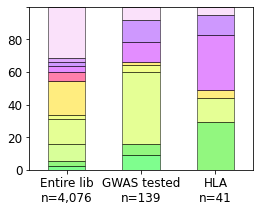

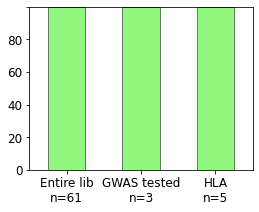

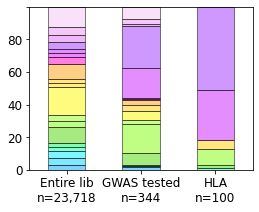

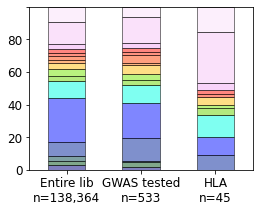

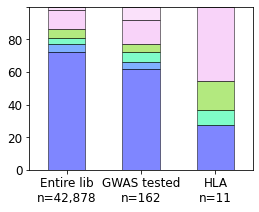

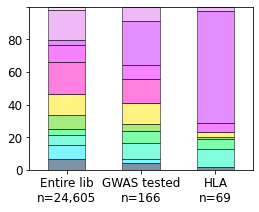

In [13]:
global groups
groups  = ['is_infect', 'is_EBV',
    'is_toxin', 'is_EM', 'is_MPA', 'is_patho']

list_subsets, colormap = parse_and_plot_species(whole_df, groups) # This is with staphylococcus in Gut pathogens included. Removed it in the paper.

### Analysis prevalence distributions

In [14]:
df_not_HLA_agilent = df_agilent[(df_agilent['peptide_name'].isin(df['peptide']) == False) &
                                (df_agilent['peptide_name'].isin(df2_2['peptide']))]


In [15]:
table_prevalences= df_GWAS
table_prevalences = table_prevalences[['Peptide', 'Prevalence_IBD', 'Prevalence_LLD']]
LLD_n = 1437 # As specified in the results first paragraph
IBD_n = 497 # As specified in the results first paragraph
n_tot = LLD_n + IBD_n
print(n_tot)
table_prevalences['Prevalence_IBD_tot'] = table_prevalences['Prevalence_IBD'].apply(lambda x: ((x*IBD_n)/n_tot))
table_prevalences['Prevalence_LLD_tot'] = table_prevalences['Prevalence_LLD'].apply(lambda x: ((x*LLD_n)/n_tot))
table_prevalences['Prevalence_tot'] = table_prevalences['Prevalence_IBD_tot'] + table_prevalences['Prevalence_LLD_tot']

# Only agilent
table_prevalences_agilent = table_prevalences[table_prevalences['Peptide'].str.contains('agilent')]

np.quantile(table_prevalences_agilent['Prevalence_tot'], 0.90)

intervals = [(0,0.1), (0.1,0.2), (0.2,0.5), (0.5,1)]
labels = ("1", "2", "3", "4")

# Function to map prevalence values to intervals. #TODO: Include it in add_features script
def map_interval(val):
    for i, interval in enumerate(intervals):
        if interval[0] <= val < interval[1]:
            return labels[i]
    return None

table_prevalences_agilent['Interval'] = table_prevalences_agilent['Prevalence_tot'].map(
    map_interval
    )


1934


/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/3191238374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_prevalences['Prevalence_IBD_tot'] = table_prevalences['Prevalence_IBD'].apply(lambda x: ((x*IBD_n)/n_tot))
/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/3191238374.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_prevalences['Prevalence_LLD_tot'] = table_prevalences['Prevalence_LLD'].apply(lambda x: ((x*LLD_n)/n_tot))
/var/folders/lx/dvbfjqsd7wq4sr

In [16]:
HLA_prevalences_table = pd.merge(df_agilent_final[['peptide_name', 'prot_num']],
                          table_prevalences_agilent,
                          left_on='peptide_name',
                          right_on='Peptide')
non_HLA_associated_prevalences = pd.merge(df_not_HLA_agilent[['peptide_name', 'prot_num']],
                          table_prevalences_agilent,
                          left_on='peptide_name',
                          right_on='Peptide')


#### Compute Kolmogorov Smirnov test over the 3 prevalence distributions

In [17]:
import scipy.stats as stats
import math

In [18]:
# Perform the Kolmogorov-Smirnov test
statistic, p_value = stats.ks_2samp(table_prevalences_agilent['Prevalence_tot'],
                                    HLA_prevalences_table['Prevalence_tot'])

# Print the test statistic and p-value
print("Test statistic:", statistic)
print("P-value:", p_value)


# Perform the Kolmogorov-Smirnov test for each pair of populations
statistic12, p_value12 = stats.ks_2samp(table_prevalences_agilent['Prevalence_tot'],
                                    HLA_prevalences_table['Prevalence_tot'])
statistic13, p_value13 = stats.ks_2samp(HLA_prevalences_table['Prevalence_tot'],
                                    non_HLA_associated_prevalences['Prevalence_tot'])
statistic23, p_value23 = stats.ks_2samp(non_HLA_associated_prevalences['Prevalence_tot'],
                                    table_prevalences_agilent['Prevalence_tot'])

# Create a list of the test statistics and p-values
statistics = [statistic12, statistic13, statistic23]
p_values = [p_value12, p_value13, p_value23]
labels = ['total antibody bound', 'HLA', 'non_HLA'] 

# compare them using boxplots
import seaborn as sns
#plt.figure(figsize=(15,10))
table_distributions = pd.DataFrame({'peptides' : table_prevalences_agilent['Peptide'], 'HLA associations tested' : table_prevalences_agilent['Prevalence_tot'],
              'HLA associations found (by imputation)' : HLA_prevalences_table['Prevalence_tot'], 
              'HLA associations not found' : non_HLA_associated_prevalences['Prevalence_tot']})

# Create a long format table using the melt function
melted_table_distributions = table_distributions.melt(id_vars=['peptides'])

Test statistic: 0.21975007046885275
P-value: 5.36580633568276e-12


Text(0, 0.5, 'Count of Peptides')

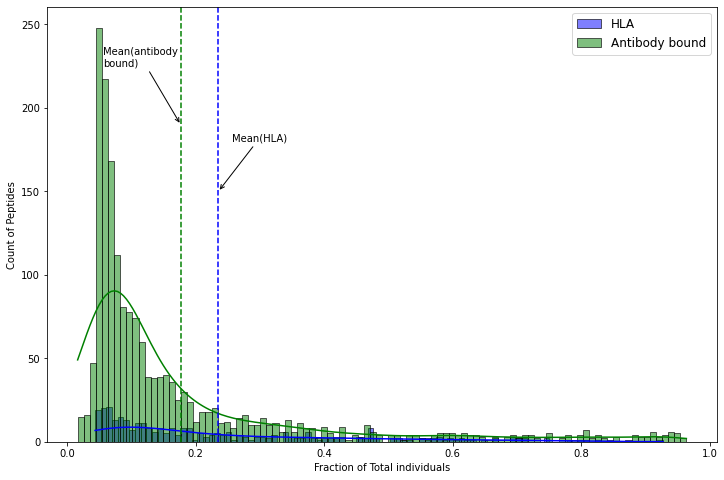

In [19]:
plt.figure(figsize=(12,8))

# Use seaborn to plot the histograms
sns.histplot(data=melted_table_distributions, x=melted_table_distributions[
    melted_table_distributions['variable'] == 'HLA associations found (by imputation)']['value'], bins=100, kde=True, color='blue',
    alpha=0.5, label='HLA')
sns.histplot(data=melted_table_distributions, x=melted_table_distributions[
    melted_table_distributions['variable'] == 'HLA associations tested']['value'], bins=100, kde=True, color='green',
    alpha=0.5, label='Antibody bound')
#plt.axvline(x=3, color='red', linestyle='--')

plt.axvline(x=np.mean(table_prevalences_agilent['Prevalence_tot']), color='green', linestyle='--')
plt.axvline(x=np.mean(HLA_prevalences_table['Prevalence_tot']), color='blue', linestyle='--')
plt.annotate('Mean(antibody\nbound)', xy=(np.mean(table_prevalences_agilent['Prevalence_tot']),190), xytext=(np.mean(table_prevalences_agilent['Prevalence_tot'])-.12, 225),
             arrowprops=dict(arrowstyle='->'))
plt.annotate('Mean(HLA)', xy=(np.mean(HLA_prevalences_table['Prevalence_tot']),150), xytext=(np.mean(table_prevalences_agilent['Prevalence_tot'])+.08, 180),
             arrowprops=dict(arrowstyle='->'))
plt.legend(fontsize=12)
plt.xlabel('Fraction of Total individuals')
plt.ylabel('Count of Peptides')

In [20]:
from utils.stats_and_plot_utils import barplot_annotate_brackets

5.36580633568276e-12
4.104538593220016e-10
0.01564683570271228


Text(0, 0.5, 'Fraction of population')

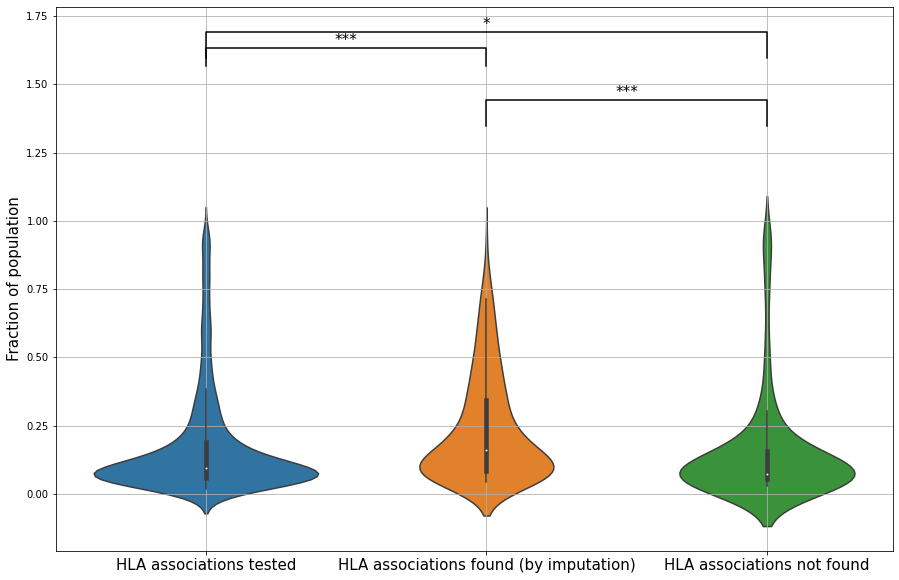

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
sns.violinplot(data=melted_table_distributions, x='variable',
            y='value')


count = 0
maximum = 0

#print(ax)
#print(f"ax patches are: {[x for x in ax.patches]}")
for rect in ax.patches:
    #print(rect)
    if np.isnan(rect.get_height()) == False:
        #print(count)
        #print(rect.get_height(), values[count], sep='\t')
        if rect.get_height() > maximum:
            maximum = rect.get_height()
            maximum = maximum
   #print(rect)
maximum = maximum/10 + 1

heights=[1.50, 1.25, 1]
bars = np.arange(len(heights))
for i in range(3):
    print(p_values[i])
barplot_annotate_brackets(0, 1, p_values[0], bars, heights, maxasterix=3, fs=15)
barplot_annotate_brackets(1, 2, p_values[1], bars, heights, maxasterix=3, fs=15)
barplot_annotate_brackets(0, 2, p_values[2], bars, heights, maxasterix=3, fs=15)
plt.grid()
plt.xticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Fraction of population', fontsize=15)

### Use alleles information and plot alleles distribution in the different categories

In [22]:
from utils.stats_and_plot_utils import chi_squared_test_groups_alleles
from statsmodels.stats.multitest import multipletests

(812, 21)
(405, 21)


/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/3598546405.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_assoc_gene_HLAII['allele'] = df_merged_assoc_gene_HLAII[['Variant']].apply(lambda x: ['_'.join(y.split('_')[1:]) for y in x])
/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/3598546405.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_functions['allele'] = df_merged_assoc_gene_HLAII['allele']
/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/i

405
['thistle', 'tab:blue', 'indianred', 'lightsalmon', 'mediumseagreen', 'gold']


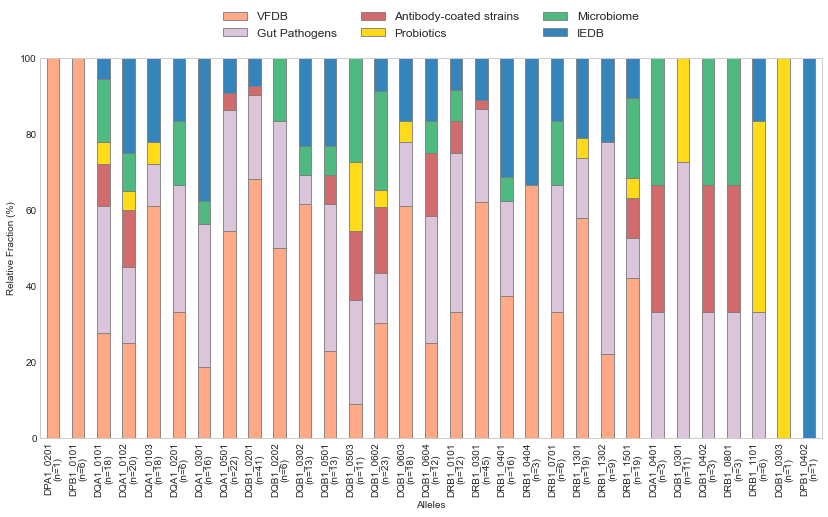

In [23]:
df_assoc_reduced = df[['Variant', 'peptide', 'Bonferroni_ind']]

df_merged_assoc = pd.merge(df_assoc_reduced, df_agilent_final, left_on='peptide', right_on='peptide_name')[[
    'Variant',
    'peptide',
    'Bonferroni_ind',
    'is_pos_cntrl', 'is_neg_cntrl',
    'is_rand_cntrl', 'is_auto', 'is_infect', 'is_EBV',
    'is_toxin', 'is_EM', 'is_MPA', 'is_patho', 'is_IgA', 'is_probio',
    'signalp6_slow', 
    'diamond_mmseqs_intersec_toxin',
    'is_flagellum',
    'uniref_func',
    'is_topgraph_new_&_old'
]]
df_merged_assoc_gene_HLAII = df_merged_assoc[(df_merged_assoc['Variant'].str.contains('_')) & 
                (df_merged_assoc['Variant'].str.contains('HLA'))]
df_merged_assoc_gene_HLAII['allele'] = df_merged_assoc_gene_HLAII[['Variant']].apply(lambda x: ['_'.join(y.split('_')[1:]) for y in x])
# df_merged_assoc_gene['allele'] = df_merged_assoc_gene[['allele']].apply(lambda x: '_'.join(x)
# Select ony specific alleles
print(df_merged_assoc_gene_HLAII.shape)
df_merged_assoc_gene_HLAII = df_merged_assoc_gene_HLAII[df_merged_assoc_gene_HLAII['allele'].str.len() > 7]
print(df_merged_assoc_gene_HLAII.shape)
counts_known_allele = df_merged_assoc_gene_HLAII.groupby(['peptide', 'allele']).count()[['Variant']]

counts_known_allele_wide = counts_known_allele.unstack().fillna(0)
# Remove the first level in columns ('Variant')
counts_known_allele_wide.columns = counts_known_allele_wide.columns.droplevel(0)
counts_known_allele_wide.index.name = None
counts_known_allele_wide.columns.name = None
counts_known_allele_wide

# Rearrange the dataframe in order to contain clear peptide assignment to each group:
# NOT MANDATORY:
# Rearrange the dataframe in order to contain clear peptide assignment to each group:
# NOT MANDATORY:
# Reassign sources in order to avoid overlaps of a single peptide in more than 1 categories
excluded_columns = [0, 2, 19, 20]
selected_functions = df_merged_assoc_gene_HLAII.iloc[:, [i for i in range(df.shape[1]) if i not in excluded_columns]]
selected_functions['allele'] = df_merged_assoc_gene_HLAII['allele']
#print([df_merged_assoc_selected.columns[i] for i in range(df_merged_assoc_selected.shape[1])])
# First I only selected the sources
selected_functions_sources = selected_functions[['peptide', 'is_auto', 'is_infect', 'is_EBV',
    'is_toxin', 'is_EM', 'is_MPA', 'is_patho', 'is_IgA', 'is_probio', 'allele']]
# plot_upset(selected_functions_sources,
#             selected_functions_sources[['is_auto', 'is_infect', 'is_EBV',
#     'is_toxin', 'is_EM', 'is_MPA', 'is_patho', 'is_IgA', 'is_probio']])
# plt.savefig('Analysis_flagellum_peptides_CFS/PCA/overlaps_categories_sources1.png',facecolor='white',
#             transparent=False,
#             bbox_inches = 'tight')

selected_functions_sources['Microbiome'] = selected_functions_sources['is_EM'] + selected_functions_sources['is_MPA']

selected_functions_sources['IEBD_EBV_auto'] = selected_functions_sources['is_EBV'] +\
    selected_functions_sources['is_auto'] +\
    selected_functions_sources['is_infect']

selected_functions_collapsed = selected_functions_sources[['peptide', 'is_toxin', 'is_patho', 'is_IgA', 'is_probio', 'Microbiome', 'IEBD_EBV_auto', 'allele']]

# plot_upset(selected_functions_collapsed,
#             selected_functions_collapsed[['is_toxin', 'is_patho', 'is_IgA', 'is_probio', 'Microbiome', 'IEBD_EBV_auto']])

# Do the same but with alleles on x and categories in the bars

series_prevalences= []
series_counts = []
nassoc = []

# groups = set(selected_functions_collapsed['allele'])
groups = ['is_toxin', 'is_patho', 'is_IgA', 'is_probio', 'Microbiome', 'IEBD_EBV_auto']

for i in groups:
    df_merged_assoc_known_allele_reduced = selected_functions_collapsed[selected_functions_collapsed[i] == 1]
    #nassoc.append(len(df_merged_assoc_known_allele_reduced))
    #print(nassoc)
    #print(i, len(df_merged_assoc_known_allele))
    # Group By the peptide and the allele
    counts_known_allele = df_merged_assoc_known_allele_reduced.groupby(['allele', 'peptide']).count().iloc[:,0]
    #nassoc.append(len(counts_known_allele))
    # Unstack to make table in wide format and replace nan values with 0
    counts_known_allele_wide = counts_known_allele.unstack().fillna(0)
    counts_known_allele_wide.columns.name = None
    counts_known_allele_wide.index.name = None
    series_counts.append(counts_known_allele_wide.sum(axis=1))
#concat_perc_allele = pd.concat(series_prevalences, axis=1).fillna(0)
concat_count_allele = pd.concat(series_counts, axis=1).fillna(0)
#concat_count_allele[]
rowsums = concat_count_allele.sum(axis=1)

concat_perc_allele = (concat_count_allele.div(rowsums,axis=0)*100).round(3)
#print(concat_count_allele)
#concat_count_allele = concat_count_allele.transpose()
concat_perc_allele.columns =  concat_count_allele.columns = ['is_toxin', 'is_patho', 'is_IgA', 'is_probio', 'Microbiome', 'IEBD_EBV_auto']

concat_perc_allele.index = [x+'\n(n='+str(int(y))+')' for x,y in zip(concat_perc_allele.index,
                                                    rowsums)]

print(len(selected_functions_collapsed))
# Statistic test
grouped_concat, grouped_concat_perc, chi2_test = chi_squared_test_groups_alleles(selected_functions_collapsed, by='allele', groups=
                                                                         ['is_toxin', 'is_patho', 'is_IgA', 'is_probio', 'Microbiome', 'IEBD_EBV_auto'], save='',
                                                                         statistic=True)
grouped_concat_perc.columns = ['VFDB', 'Gut Pathogens', 'Antibody-coated strains', 'Probiotics', 'Microbiome', 'IEDB']
from matplotlib import cm
plt.style.use('seaborn-whitegrid')

cmap_dict =  {
'IEDB': 'tab:blue',
'VFDB': 'lightsalmon',
'Microbiome': 'mediumseagreen',
'Gut Pathogens': 'thistle',
'Antibody-coated strains' : 'indianred',
'Probiotics' : 'gold'} 


#cmap = cm.get_cmap('tab20')
from matplotlib.colors import ListedColormap
cimap = ListedColormap([cmap_dict[c] for c in grouped_concat_perc.columns])
print([cmap_dict[c] for c in set(grouped_concat_perc.columns)])
fig, ax = plt.subplots(1, figsize=(14,7))
p = grouped_concat_perc.plot(kind='bar', stacked=True,\
    ax=ax, edgecolor='grey', cmap=cimap, alpha=.9)
ax.grid(False)
# # Highlight just the ones which are Microbiota (mach index 4) or Antibody-coated strains (match index 2)
# print(grouped_concat_perc.columns)
# list_values_to_reduce_alpha = []
# c1 = 0
# for k in grouped_concat_perc.values:
#     no_zeros = np.where(k!=0)
#     print(no_zeros[0])
#     for i in no_zeros[0]:
#         if i == 2:
#             print(no_zeros[0], 'matched', c1+2)
#             list_values_to_reduce_alpha.append(c1+2)
#         if i == 4:
#             print(no_zeros[0], 'matched', c1+4)
#             list_values_to_reduce_alpha.append(c1+4)
#     #print(len(no_zeros))
#     c1 += len(no_zeros[0])
#print(list_values_to_reduce_alpha)

ax.set_ylim(0,100)
ax.legend('')
ax.set_ylabel('Relative Fraction (%)')
ax.set_xlabel('Alleles')
ax.legend(bbox_to_anchor=(0.5, 1.15), fontsize=12, loc='upper center', ncol=3)
plt.savefig('SupplemeStacked_barplot_all_genes_hierarchical.png', facecolor='white',\
    dpi=300,
        transparent=False,
        bbox_inches = 'tight')

### Show Manhattan plot

['DQA1', 'DQA1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DQB1', 'DQB1', 'DQB1', 'DQB1', 'DQB1', 'DQB1', 'DQB1', 'DQB1', 'DQB1', 'DQB1', 'DQB1', 'DQB1', 'DQA1', 'DQA1', 'DQB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DQB1', 'DRB1', 'DQA1', 'DQA1', 'DQA1', 'DQB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DQA1', 'DRB1', 'DRB1', 'DQB1', 'DRB1', 'DQB1', 'DQB1', 'DRB1', 'DRB1', 'DRB1', 'DQA1', 'DQA1', 'DQA1', 'DQA1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DQA1', 'DQA1', 'DRB1', 'DRB1', 'DQA1', 'DQA1', 'DQA1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1', 'DRB1',

/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/3488974247.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['neg_log_p'] = -np.log10(df_selected['P'])
/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/3488974247.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GWAS_df['CHR'] = GWAS_df['MarkerName'].apply(lambda x: int(x.split(':')[0]))
/var/folders/lx/dvbfjqsd7wq4sr2wbc_g52p40000gn/T/ipykernel_51010/3488974247.py:27: SettingWithCopyWarning: 
A value is try

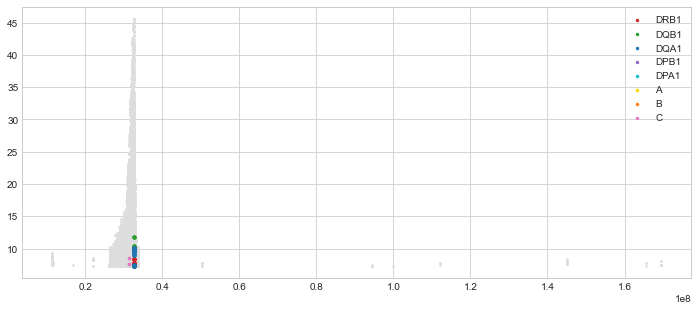

In [24]:
df_HLA = df[(df['Variant'].str.contains('_'))]
HLA_index = df[(df['Variant'].str.contains('_'))].index
list_HLA_allele = df_HLA[['Variant']].apply(lambda x: [y.split('_')[1] for y in x])['Variant'].tolist()
df['allele'] = np.nan
print(list_HLA_allele)
df.loc[HLA_index,'allele'] = list_HLA_allele
df['allele'] = df.loc[HLA_index,'allele']
df['allele'] = df.allele.fillna('others')

df_selected = df[['BP', 'allele', 'P']]
df_selected['neg_log_p'] = -np.log10(df_selected['P'])
df_selected_sorted = df_selected.sort_values(by='allele', ascending=False)


GWAS_df = df2_2[['MarkerName', 'P.value']]
GWAS_df.columns = ['MarkerName', 'P.value']
#GWAS_df.to_csv('significative_df.tsv', sep='\t')

#GWAS_df = GWAS_df[GWAS_df['P.value'] < 0.8]

# Use pyspark session
#import pyspark_function
#file_path = os.getcwd() + '/gwas_header.tsv'
#print(file_path)
#GWAS_df = pyspark_function.process_table(file_path, columns)
GWAS_df['CHR'] = GWAS_df['MarkerName'].apply(lambda x: int(x.split(':')[0]))
GWAS_df['BP'] = GWAS_df['MarkerName'].apply(lambda x: int(x.split(':')[1]))


merged_imputat_assoc = pd.merge(GWAS_df[GWAS_df['CHR'] == 6], df_selected_sorted, on='BP', how='left')
merged_imputat_assoc['allele'] = merged_imputat_assoc['allele'].fillna('others')

merged_imputat_assoc['neg_log_pvalue'] = -np.log10(merged_imputat_assoc['P.value'])


list_alleles = ['DRB1', 'DQB1', 'DQA1', 'DPB1', 'DPA1', 'A','B', 'C']
cmap = cm.get_cmap('tab20')
#colors = [cmap(i / len(list_alleles)) for i in range(len(list_alleles))]
plt.figure(figsize=(12,5))
# Create a dictionary to map categories to colors
#category_color_map = dict(zip(list_alleles, colors))
col_map= {'DRB1':'tab:red', 'DQB1':'tab:green', 'DQA1':'tab:blue', 'DPB1':'tab:purple', 'DPA1':'tab:cyan', 'A':'gold','B':'tab:orange', 'C':'tab:pink'}
merged_imputat_assoc[merged_imputat_assoc['allele'] == 'others']['neg_log_pvalue']
plt.scatter(x=merged_imputat_assoc[merged_imputat_assoc['allele'] == 'others']['BP'], y=merged_imputat_assoc[merged_imputat_assoc['allele'] == 'others']['neg_log_pvalue'], color='#DDDDDD', s=3)
for i in list_alleles:
    plt.scatter(x=merged_imputat_assoc[merged_imputat_assoc['allele'] == i]['BP'], y=merged_imputat_assoc[merged_imputat_assoc['allele'] == i]['neg_log_pvalue'], s=6, color=col_map[i], label=i)
plt.legend()



Text(0.5, 0, 'Chromosome 6 (Mbp)')

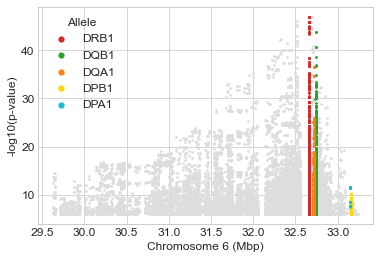

In [25]:
from matplotlib.ticker import FuncFormatter
plt.figsize=(12,6)
list_alleles = ['DRB1', 'DQB1', 'DQA1', 'DPB1', 'DPA1']# , 'A','B', 'C']
cmap = cm.get_cmap('tab20')

# Define a function to convert bp to Mbp
def bp_to_mbp(x, pos):
    return "{:.1f}".format(x / 1000000)  # Divide by 1,000,000 to convert to Mbp

#colors = [cmap(i / len(list_alleles)) for i in range(len(list_alleles))]
fig, ax = plt.subplots(1, figsize=(6,4))
# Increase the size of the x-axis ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# Create a dictionary to map categories to colors
#category_color_map = dict(zip(list_alleles, colors))
col_map= {'DRB1':'tab:red', 'DQB1':'tab:green', 'DQA1':'tab:orange', 'DPB1':'gold', 'DPA1':'tab:cyan', 'A':'tab:purple','B':'tab:blue', 'C':'tab:pink'}
df_selected[df_selected['allele'] == 'others']['neg_log_p']
plt.scatter(x=df_selected[df_selected['allele'] == 'others']['BP'], y=df_selected[df_selected['allele'] == 'others']['neg_log_p'], color='#DDDDDD', s=3)
for i in list_alleles:
    plt.scatter(x=df_selected[df_selected['allele'] == i]['BP'], y=df_selected[df_selected['allele'] == i]['neg_log_p'], s=3, color=col_map[i], label=i)
ax.xaxis.set_major_formatter(FuncFormatter(bp_to_mbp))
ax.legend(title='allele', markerscale=3., fontsize=12)
# Increase legend fotnsize
legend = ax.get_legend()
legend.set_title('Allele')
legend.get_title().set_fontsize(12)  # Adjust fontsize as needed
# Change x y labels
ax.set_ylabel('-log10(p-value)', fontsize=12)
ax.set_xlabel('Chromosome 6 (Mbp)', fontsize=12)

#legend.set_title('allele', fontsize=12) 
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
# Save
# plt.savefig('HLA_imputations_alleles.png',facecolor='white',\
#     dpi=300,
#         transparent=False,
#         bbox_inches = 'tight')

In [26]:
# Run other Manhattan plot using the cluster -> script manhattan_plot.py

In [27]:
from utils import model_utils

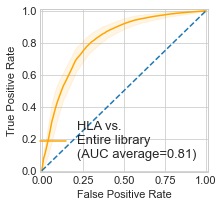

In [28]:
# For this analysis use 220 as training set and 99 as train set

features = ['is_pos_cntrl', 'is_neg_cntrl', 'is_rand_cntrl', 'is_auto', 'is_infect',
               'is_EBV', 'is_toxin', 'is_EM', 'is_MPA', 'is_patho', 'is_IgA',
               'is_probio', 'is_flagellum', 'diamond_mmseqs_intersec_toxin', 'is_topgraph_new_&_old', 'signalp6_slow']
classes = ['HLA', 'GWAS tested', 'Entire library']

feat_imp1_2class = model_utils.rf_2class_model(df_agilent_final, agilent_total_clean2, 
                names=['HLA', 'Entire library'], 
                train_size=220, 
                test_size=99,
                features=features,
                color_curve='orange')



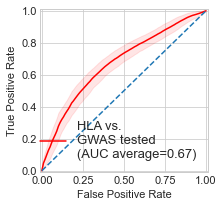

In [29]:
feat_imp2_2class = model_utils.rf_2class_model(df_agilent_final, df_tested_agilent_clean, 
                names = ['HLA', 'GWAS tested'],
                features=features,
                train_size = 220, 
                test_size = 99, 
                color_curve = 'red')

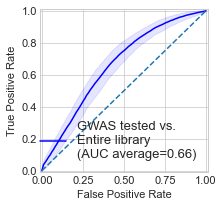

In [30]:
feat_imp3_2class = model_utils.rf_2class_model(df_tested_agilent_clean, agilent_total_clean2, 
                names=['GWAS tested', 'Entire library'],
                features=features,
                train_size=220, 
                test_size=99, 
                color_curve='blue')

                             comparison       variable     value
0        HLA associated vs. GWAS tested          is_EM  0.305499
1        HLA associated vs. GWAS tested          is_EM  0.248119
2        HLA associated vs. GWAS tested          is_EM  0.274210
3        HLA associated vs. GWAS tested          is_EM  0.240414
4        HLA associated vs. GWAS tested          is_EM  0.295958
...                                 ...            ...       ...
4795  HLA associated vs. Entire library  is_rand_cntrl  0.000000
4796  HLA associated vs. Entire library  is_rand_cntrl  0.000000
4797  HLA associated vs. Entire library  is_rand_cntrl  0.000000
4798  HLA associated vs. Entire library  is_rand_cntrl  0.000000
4799  HLA associated vs. Entire library  is_rand_cntrl  0.006697

[4800 rows x 3 columns]


Text(0, 0.5, 'Feature Importance\n(Mean decrease in impurity)')

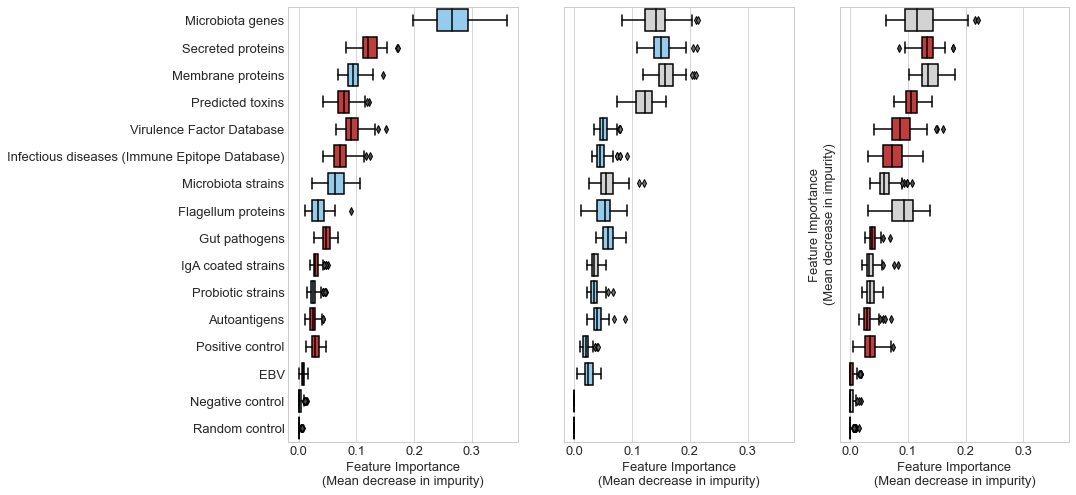

In [31]:
# Plot feature importances using mean decrease in impurity

model_utils.grouped_featureImp_box(feat_imp1_2class, \
    feat_imp2_2class, \
        feat_imp3_2class,\
        df_agilent_final,\
        df_tested_agilent_clean,\
        agilent_total_clean2,\
            features,\
                 comparisons=['HLA associated vs. GWAS tested', 'GWAS tested vs. Entire library', 'HLA associated vs. Entire library'])
plt.ylabel('Feature Importance\n(Mean decrease in impurity)')
